In [1]:
import os
import sys
sys.path.append("/home/haogaoyang/code/Singlecell/scAGDE_revise/scAGDE/")

# Tutorial 5: End-to-end scATAC-seq analysis

Here we will use scATAC-seq dataset `HumanAtlas' as an example to illustrate how scAGDE performs large-scale scATAC-seq analysis in an end-to-end style.

## 1. Read and preprocess data

We first read '.h5ad' data file using [Scanpy](https://github.com/scverse/scanpy) package

In [2]:
import scanpy as sc
# adata = sc.read_h5ad("data/HumanAtlas.h5ad")
adata = sc.read_h5ad("data/10XBlood.h5ad")

We can use Scanpy to further filter data. In our case, we pass this step because the loaded dataset has been preprocessed. Some codes for filtering are copied below for easy reference:

In [3]:
# sc.pp.filter_cells(adata, min_genes=100)
# min_cells = int(adata.shape[0] * 0.01)
# sc.pp.filter_genes(adata, min_cells=min_cells)

In [4]:
adata

AnnData object with n_obs × n_vars = 17736 × 39565
    obs: 'orig.ident', 'nCount_scATACseq', 'nFeature_scATACseq', 'celltype', 'n_genes'
    var: 'features', 'n_cells'
    uns: 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## 2. Setup and train scAGDE model

Now we can initialize the trainer with the AnnData object, which will ensure settings for model are in place for training. 

We can specify the `outdir` to the dir path where we want to save the output file (mainly the model weights file).

`n_centroids` represents the cluster number of dataset. If this information is unknown, we can set `n_centroids=None` and in this case, scAGDE will apply the estimation strategy to estimate the optimal cluster number for the initialization of its cluster layer. Here, we set `n_centroids=8`.
 
We can train scAGDE on specified device by setting `gpu`. For example, train scAGDE on CPUs by `gpu=None` and trian it on GPU #0 by `gpu="0"`

In [5]:
import scAGDE
trainer = scAGDE.Trainer_scale(adata,outdir="output",n_centroids=9,gpu="1",early_stopping=True,patience=50,clip=0)

device used: cuda:1



Now we can train scAGDE model in end-to-end style. The whole pipeline behind the function of `fit()` mainly consists of three stages, as below:

1. scAGDE first trained an chromatin accessibility-based autoencoder to measure the importance of the peaks and select the key peaks. The number of selected peaks is set to 10,000 in default, or you can change it by setting `top_n`. In the meanwhile, the initial cell representations for cell graph construction are stored in `adata.obs[embed_init_key]`, which is `"latent_init"` in default.

2. scAGDE then constructed cell graph and trains the GCN-based embedded model to  extract essential structural information from both count and cell graph data.

3. scAGDE finally yiels robust and discriminative cell embeddings which are stored in `adata.obsm[embed_key]`, which is `"latent"` in default. Also, scAGDE enables imputation task if `impute_key` is not None and the imputed data will be stored in `adata.obsm[impute_key]`, which is `"impute"` in default. 

scAGDE performs clustering on final embeddings if `cluster_key` is not None, and the cluster assignments will be in `adata.obs[cluster_key]`, which is `"cluster"` in default. The cluster number is the value of `n_centroids` and if estimation is used, the cluster number is the value of estimated cluster number.

You can also explore each step as you wish by following a step-by-step tutorial in [Tutorial 2: Step-by-Step scATAC-seq analysis](./Tutorial%202:%20Step-by-Step%20scATAC-seq%20analysis.ipynb).

In [6]:
embed_key = "latent"
# trainer.max_iter1 = 500
# trainer.pretrain_iter = 500
# trainer.max_iter2 = 500
adata = trainer.fit(topn=10000,embed_key=embed_key)
print(adata)

Cell number: 17736
Peak number: 39565
n_centroids: 9


## Training CountModel ##


Epochs: 100%|██████████| 200/200 [20:47<00:00,  6.24s/it, loss=8473.8076] 



## Constructing Cell Graph ##
Cell number: 17736
Peak number: 10000
n_centroids: 9


## Training GraphModel ##


Epochs:  71%|███████   | 212/300 [12:48<05:18,  3.62s/it]


early stopping


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



AnnData object with n_obs × n_vars = 17736 × 39565
    obs: 'orig.ident', 'nCount_scATACseq', 'nFeature_scATACseq', 'celltype', 'n_genes', 'cluster'
    var: 'features', 'n_cells', 'is_selected'
    uns: 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'latent_init', 'impute', 'latent'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [7]:
# trainer.early_stopping = False
# adata = trainer.GraphModel()

In [8]:
# import numpy as np


# def mclust_R(data, num_cluster, modelNames='EEE', random_seed=18):
#     """\
#     Clustering using the mclust algorithm.
#     The parameters are the same as those in the R package mclust.
#     """

#     np.random.seed(random_seed)
#     import rpy2.robjects as robjects
#     robjects.r.library("mclust")

#     import rpy2.robjects.numpy2ri
#     rpy2.robjects.numpy2ri.activate()
#     r_random_seed = robjects.r['set.seed']
#     r_random_seed(random_seed)
#     rmclust = robjects.r['Mclust']
#     robjects.r['mclust.options'](subset=10000)
#     try:
#         res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(data), num_cluster, modelNames)
#         mclust_res = np.array(res[-2])

#     except TypeError:
#         mclust_res = np.ones(len(data))
#         mclust_res[0] = 0

#     return mclust_res


In [9]:
# cluster = mclust_R(adata.obsm["latent"],9,"EEE")
# adata.obs["mclust"] = cluster

In [10]:
# np.unique(cluster)

In [12]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=9, n_init=5, random_state=0)
kmeans.fit_predict(adata.obsm["latent"])
adata.obs["kmeans"] = kmeans.labels_.astype(str)
adata.obs["celltype"] = adata.obs["celltype"].astype(str)

## 3. Visualizing and evaluation

We can now use Scanpy to visualize our latent space.

/home/haogaoyang/anaconda3/envs/torch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/haogaoyang/anaconda3/envs/torch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/haogaoyang/anaconda3/envs/torch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


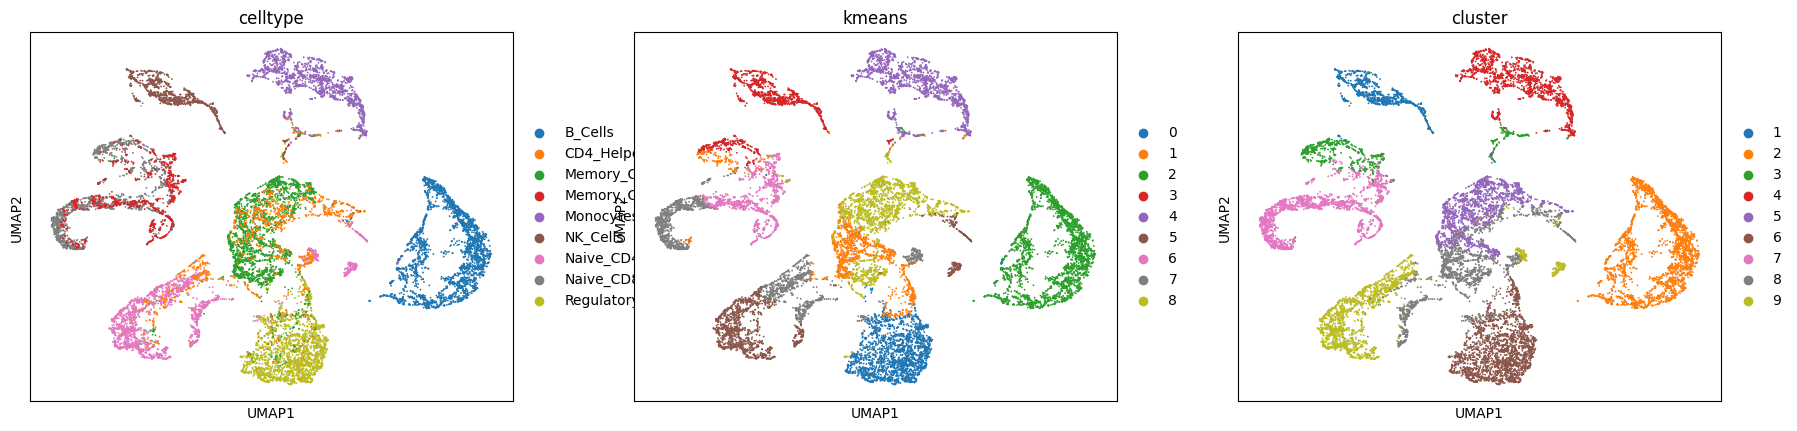

In [13]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata, min_dist=0.2)
sc.pl.umap(adata,color=["celltype","kmeans","cluster"])

/home/haogaoyang/anaconda3/envs/torch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/haogaoyang/anaconda3/envs/torch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


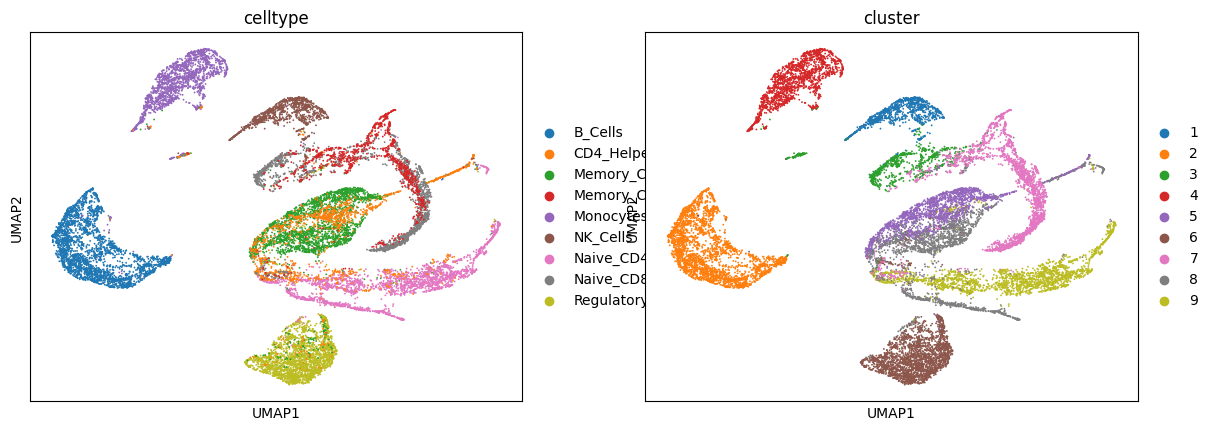

In [14]:
sc.pp.neighbors(adata, use_rep="latent_init")
sc.tl.umap(adata, min_dist=0.2)
sc.pl.umap(adata,color=["celltype","cluster"])

We can evaluate the clustering performance with multiple metrics as below:

In [15]:
y = adata.obs["celltype"].astype("category").cat.codes.values
res = scAGDE.utils.cluster_report(y, adata.obs["kmeans"].astype(int))


## Clustering Evaluation Report ##
# Confusion matrix: #
[[2913    1    2    0    1    0    4    1    0]
 [   1  245  631    0   25    4  137  290   57]
 [   0  989 1388    0   16    1   37    8  120]
 [   0   79   46  711    2   30    0  191    0]
 [  41    8    5    0 1725   18    3   17    8]
 [   0   15   16    0    0 1052    1    0    0]
 [   0    8    9    2    5    0 1646  784    7]
 [   1  145    2  479    1  315    2  949    4]
 [   0  182  117    0    0    4    6   41 2188]]
# Metric values: #
Adjusted Rand Index: 0.6407
Normalized Mutual Info: 0.6965
F1 score: 0.7227


In [16]:
y = adata.obs["celltype"].astype("category").cat.codes.values
res = scAGDE.utils.cluster_report(y, adata.obs["cluster"].astype(int))


## Clustering Evaluation Report ##
# Confusion matrix: #
[[2913    2    2    0    1    0    2    1    1]
 [   0  462  527   41    9    0  278    0   73]
 [   0  928 1399   33    6    0   66    0  127]
 [   0   33    0  168    0    0    0  857    1]
 [  36    2    2   58 1703   13    2    1    8]
 [   0    0    5   42    0 1035    1    1    0]
 [   0  589    4    8    3    0 1847    2    8]
 [   3    3    2  515    1    3    5 1366    0]
 [   0  124   56   19    0    0    0    0 2339]]
# Metric values: #
Adjusted Rand Index: 0.6870
Normalized Mutual Info: 0.7471
F1 score: 0.7461
